In [1]:
import pandas as pd
import numpy as np
import itertools

from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import fetch_openml
import seaborn as sns
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline


import matplotlib.pyplot as plt
import warnings
import missingno as msno
import plotly.express as px

warnings.filterwarnings('ignore')


As raw data collection, i used the Breast Cancer Wisconsin (Diagnostic) Dataset and the models will be trained to predict whether a patient has breast cancer or not by specifying whether a tumor is malignant (meaning that it contains cancerous cells) or benign (doesn't contain cancerous cells).

Breast cancer is the most common cancer amongst women in the world. It accounts for 25% of all cancer cases, and affected over 2.1 Million people in 2015 alone. It starts when cells in the breast begin to grow out of control. These cells usually form tumors that can be seen via X-ray or felt as lumps in the breast area.

## Loading the data

In [2]:
df = pd.read_csv('breast-cancer.csv')

In [3]:
px.histogram(data_frame=df, x='diagnosis', color='diagnosis',color_discrete_sequence=['#05445E','#75E6DA'])

## Dealing with missing values

To further analyze the data, i started by making sure that there was no missing values in the data to make sure that the accuracy of the models are at best and to obtain more reliable predictions.

In [4]:
missing_values = df.isnull().sum() / len(df) * 100
print(missing_values)

id                         0.0
diagnosis                  0.0
radius_mean                0.0
texture_mean               0.0
perimeter_mean             0.0
area_mean                  0.0
smoothness_mean            0.0
compactness_mean           0.0
concavity_mean             0.0
concave points_mean        0.0
symmetry_mean              0.0
fractal_dimension_mean     0.0
radius_se                  0.0
texture_se                 0.0
perimeter_se               0.0
area_se                    0.0
smoothness_se              0.0
compactness_se             0.0
concavity_se               0.0
concave points_se          0.0
symmetry_se                0.0
fractal_dimension_se       0.0
radius_worst               0.0
texture_worst              0.0
perimeter_worst            0.0
area_worst                 0.0
smoothness_worst           0.0
compactness_worst          0.0
concavity_worst            0.0
concave points_worst       0.0
symmetry_worst             0.0
fractal_dimension_worst    0.0
dtype: f

It appears that my data does not have any missing values, so i will keep it as it is. 

<AxesSubplot: >

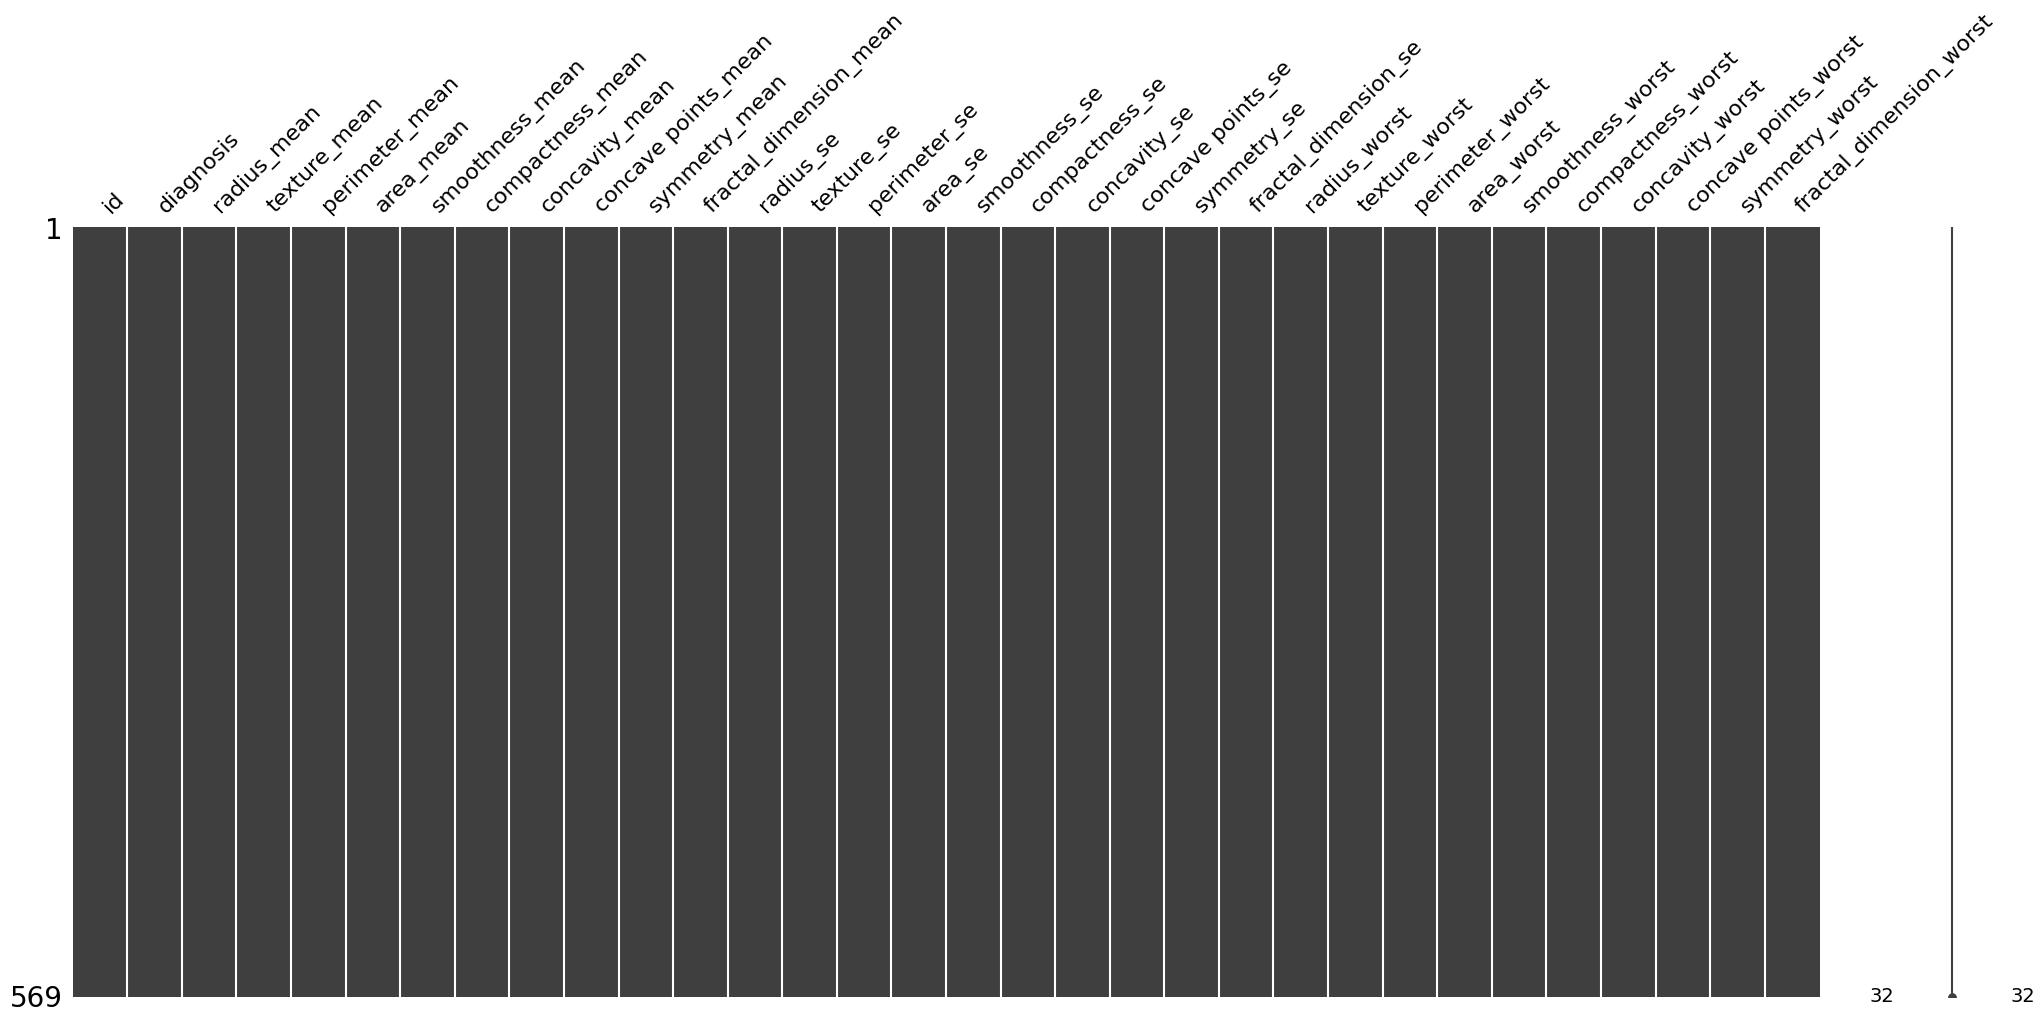

In [5]:
msno.matrix(df) #visualizing it for better analyzation

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [7]:
del df['id']

Since the patients' ids are not of relevance to my project, i have decided to delete the column of IDs. As well as i thought that if I include the patient IDs as a feature in my model, it's possible that it will overfit to the IDs rather than the underlying patterns in the data.

In [8]:
df['diagnosis'].unique()

array(['M', 'B'], dtype=object)

Moving the target column 'Diagnosis' to be the last column:

In [9]:
data=df[[col for col in df.columns if col!='diagnosis']+['diagnosis']]
data

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,M
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,M
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,M
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,M


We don't have any categorical data other than 'diagnosis', but as for this step, I created a list called num_data adding all the columns except for diagnosis and another one only for diagnosis to make the code more understandable and less prone to errors.

In [10]:
num_cols = [col for col in data.columns if col != 'diagnosis']
cat_cols = ['diagnosis']

## Data Transformation 

Since my dataset does not require alot of pre-processing steps and the dataset is not too complex, i decided not to use a Column Transformer and instead apply the transformers individually.

In [11]:
l1=LabelEncoder()
data['diagnosis']=l1.fit_transform(data['diagnosis'])
data['diagnosis'].unique()

array([1, 0])

In [12]:
x=data.iloc[:,:-1].values #all the data except for 'diagnosis'
y=data.iloc[:,-1].values # target data 'diagnosis'

I started by applying Label encoder to the 'diagnosis' column to transform the catogorical data into a numerical one, in this case, as i checkec using the unique() function, it showed the array of diagnosis equal to [M, B], so now the label encoder will assign the value 1 to M (Malignant Tumor) and 0 to B (Benign Tumor) allowing the algorithms to better process the data.

In [13]:
Scaler = StandardScaler()
x_scaled = Scaler.fit_transform(data[num_cols])

Then, for the numerical data, I used the StandardScaler transformer to standarize it.

<AxesSubplot: ylabel='Density'>

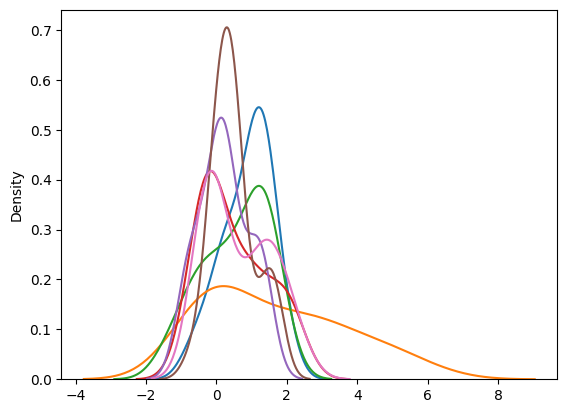

In [14]:
sns.kdeplot(x_scaled[2])
sns.kdeplot(x_scaled[3])
sns.kdeplot(x_scaled[4])
sns.kdeplot(x_scaled[5])
sns.kdeplot(x_scaled[6])
sns.kdeplot(x_scaled[7])
sns.kdeplot(x_scaled[8])

Then, I plotted the kernel density estimates (KDE) of the standardized numerical data for columns 2 to 8 using Seaborn's kdeplot function. It is used to visualize the distribution of each numerical variable after scaling.
The purpose of this code is to gain insight into the distribution of the numerical variables before and after scaling. The KDE plot shows the shape of the distribution and helps to identify any outliers or skewness.
And from the above visualization, we can deduce that the data is properly scaled.

In [15]:
print("Mean of the scaled data:", x_scaled.mean())
print("Standard deviation of the scaled data:", x_scaled.std())

Mean of the scaled data: -6.826538293184326e-17
Standard deviation of the scaled data: 1.0


The mean value of the scaled data is close to zero (within the limits of floating point precision), and the standard deviation is 1; indicating that the data was properly scaled.

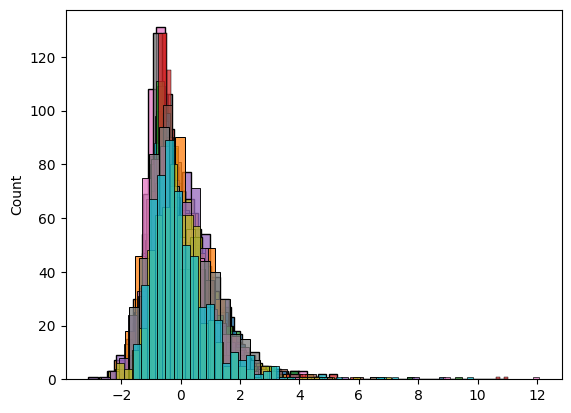

In [16]:
for i in range(x_scaled.shape[1]):
    sns.histplot(x_scaled[:, i])

Then, I ploted the histograms of all columns of the x_scaled array to see if the distributions of the scaled data are similar, again, indicating that the data was properly scaled.

## Training and test sets

In [17]:
X_train,X_test,y_train,y_test=train_test_split(x_scaled ,y ,test_size=0.2,random_state=42)

## Model Selection

Using multiple models will allow us to compare their performance and choose the best one for the breast cancer classification problem. I decided to try the following models:

###  Logistic Regression

In [18]:
lr=LogisticRegression()
lr.fit(X_train,y_train)



LogisticRegression()

Then, for each model, I decided to use the StratifiedKFold function that splits the data into k folds, where each fold is selected to preserve the percentage of samples for each class in the target variable. This is important for maintaining a representative distribution of classes in both the training and validation sets, especially for imbalanced datasets.

In [19]:
# Set up a Stratified 5-fold cross-validation for grid search
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
# Define hyperparameters to be tuned
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                     'penalty': ['l2'],
                     'fit_intercept': [True, False],
                     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


I added some hyperparameters that can be used in the logistic regression model to use them in the  GridSearch to help find the combination that produces the best performance on the validation set. I tried experimenting with differnet hyperparameters, however these ones produced the best output.

In [21]:
# Perform grid search using Stratified 5-fold cross-validation
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=skf, scoring='f1', error_score='raise')
grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise', estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'fit_intercept': [True, False], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1')

In [22]:
best_model_lr = grid_search_lr.best_estimator_
best_model_lr = lr
print(f"Best estimator: {best_model_lr}")

Best estimator: LogisticRegression()


In [23]:
# Get the accuracy of the fine-tuned model on the test set
lr_accuracy = lr.score(X_test, y_test)
print(f"Logistic Regression accuracy: {lr_accuracy}")

Logistic Regression accuracy: 0.9736842105263158


The inner_cv object will be used to evaluate the hyperparameters in each iteration of the GridSearchCV, while the outer_cv object will be used to evaluate the performance of the final model.

In [24]:
# Set up the outer cross-validation using Stratified 5-fold
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [25]:
# Set up the inner cross-validation using Stratified 5-fold
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [26]:
# Perform nested cross-validation
nested_scores = cross_val_score(best_model_lr, x_scaled, y, cv=outer_cv, scoring='accuracy', n_jobs=-1, error_score='raise')

In [27]:
# Print the scores
print(f"Nested Cross Validation Score: {np.mean(nested_scores)}")

Nested Cross Validation Score: 0.9789318428815401


Before calucalting the confusion matrix, it is necessary to make predictions on the test data using the trained logistic regression model.

In [28]:
lr_pred=lr.predict(X_test)
lr_pred

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1])

In [29]:
confusion = confusion_matrix(y_test, lr_pred)
report = classification_report(y_test, lr_pred)
precision = precision_score(y_test, lr_pred)
recall = recall_score(y_test, lr_pred)
f1 = f1_score(y_test, lr_pred)
accuracy = accuracy_score(y_test, lr_pred)
print(f"Confusion Matrix: \n{confusion}")
print(f"Classification Report: \n{report}")
print(f"Precision: {precision_score(y_test, lr_pred)}")
print(f"Recall: {recall_score(y_test, lr_pred)}")
print(f"F1 Score: {f1_score(y_test, lr_pred)}")
print(f"Accuracy: {accuracy_score(y_test, lr_pred)}\n")

Confusion Matrix: 
[[70  1]
 [ 2 41]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Precision: 0.9761904761904762
Recall: 0.9534883720930233
F1 Score: 0.9647058823529412
Accuracy: 0.9736842105263158



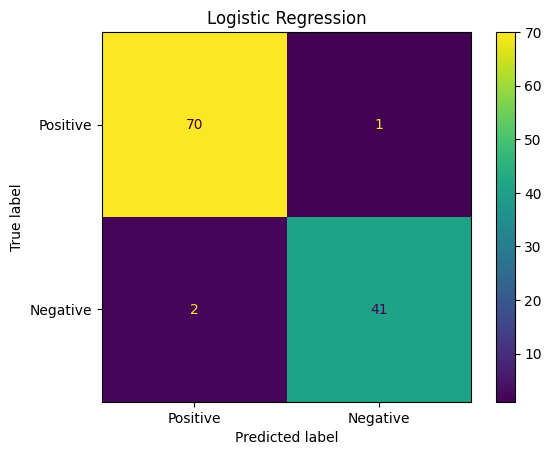

In [30]:
plot_confusion_matrix(lr, X_test, y_test, values_format='d', display_labels=['Positive','Negative'])
plt.title('Logistic Regression')
plt.show() 

### K-Nearest Neighbors

The second model i decided to try is KNN, I thought it can be a good choice for cancer classification due to its simplicity, flexibility, and ability to handle complex and varied data.

In [31]:
knn = KNeighborsClassifier(n_neighbors= 3,metric='minkowski',p=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3, p=1)

In [32]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

In [34]:
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')


In [35]:
grid_search_knn.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
             estimator=KNeighborsClassifier(n_neighbors=3, p=1), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [36]:
best_model_knn = grid_search_knn.best_estimator_
knn = best_model_knn
print(f"Best estimator: {best_model_knn}")

Best estimator: KNeighborsClassifier(p=1)


In [37]:
knn_accuracy = knn.score(X_test, y_test)
print(f"KNN accuracy: {knn_accuracy}")


KNN accuracy: 0.9649122807017544


In [38]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
nested_scores = cross_val_score(knn, x_scaled, y, cv=outer_cv, scoring='accuracy', n_jobs=-1, error_score='raise')
print(f"Nested Cross Validation Score: {np.mean(nested_scores)}")

Nested Cross Validation Score: 0.9648191274646795


In [39]:
knn_pred=knn.predict(X_test)
knn_pred

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1])

In [40]:
confusion = confusion_matrix(y_test, knn_pred)
report = classification_report(y_test, knn_pred)
precision = precision_score(y_test, knn_pred)
recall = recall_score(y_test, knn_pred)
f1 = f1_score(y_test, knn_pred)
accuracy = accuracy_score(y_test, knn_pred)
print(f"Confusion Matrix: \n{confusion}")
print(f"Classification Report: \n{report}")
print(f"Precision: {precision_score(y_test, knn_pred)}")
print(f"Recall: {recall_score(y_test, knn_pred)}")
print(f"F1 Score: {f1_score(y_test, knn_pred)}")
print(f"Accuracy: {accuracy_score(y_test, knn_pred)}\n")

Confusion Matrix: 
[[69  2]
 [ 2 41]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

Precision: 0.9534883720930233
Recall: 0.9534883720930233
F1 Score: 0.9534883720930233
Accuracy: 0.9649122807017544



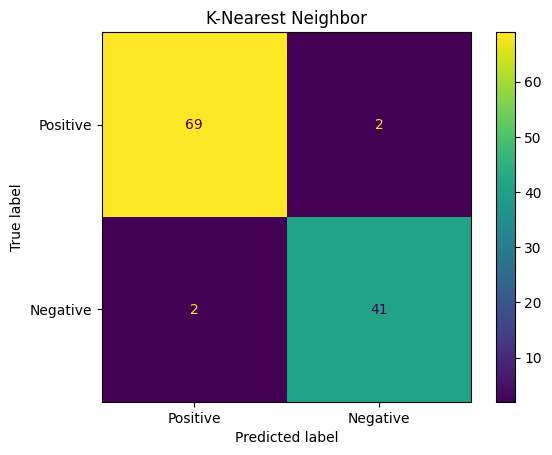

In [41]:
plot_confusion_matrix(best_model_knn, X_test, y_test, values_format='d', display_labels=['Positive','Negative'])
plt.title('K-Nearest Neighbor')
plt.show() 

### Random Forest Classifier

The third model is RFC, RFC can be a good choice for cancer classification due to its high accuracy, robustness, and ability to provide information about feature importance

In [42]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [43]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [44]:
param_grid_rfc = {'n_estimators': [100, 200],
                  'max_depth': [5, 10, 20],
                  'min_samples_split': [2, 5, 10],
                  }


In [45]:
grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv=skf, scoring='f1', error_score='raise')
grid_search_rfc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [46]:
best_model_rfc = grid_search_rfc.best_estimator_
rfc = best_model_rfc
print(f"Best estimator: {rfc}")

Best estimator: RandomForestClassifier(max_depth=10, random_state=0)


In [47]:
rfc_accuracy = rfc.score(X_test, y_test)
print(f"Random Forest Classifier accuracy: {rfc_accuracy}")

Random Forest Classifier accuracy: 0.9649122807017544


In [48]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
nested_scores = cross_val_score(rfc, x_scaled, y, cv=outer_cv, scoring='accuracy', n_jobs=-1, error_score='raise')
print(f"Nested Cross Validation Score: {np.mean(nested_scores)}")

Nested Cross Validation Score: 0.9630802670392796


In [49]:
rfc_pred = rfc.predict(X_test)
rfc_pred

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1])

In [50]:
confusion = confusion_matrix(y_test, rfc_pred)
report = classification_report(y_test, rfc_pred)
precision = precision_score(y_test, rfc_pred)
recall = recall_score(y_test, rfc_pred)
f1 = f1_score(y_test, rfc_pred)
accuracy = accuracy_score(y_test, rfc_pred)
print(f"Confusion Matrix: \n{confusion}")
print(f"Classification Report: \n{report}")
print(f"Precision: {precision_score(y_test, rfc_pred)}")
print(f"Recall: {recall_score(y_test, rfc_pred)}")
print(f"F1 Score: {f1_score(y_test, rfc_pred)}")
print(f"Accuracy: {accuracy_score(y_test, rfc_pred)}\n")

Confusion Matrix: 
[[70  1]
 [ 3 40]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Precision: 0.975609756097561
Recall: 0.9302325581395349
F1 Score: 0.9523809523809524
Accuracy: 0.9649122807017544



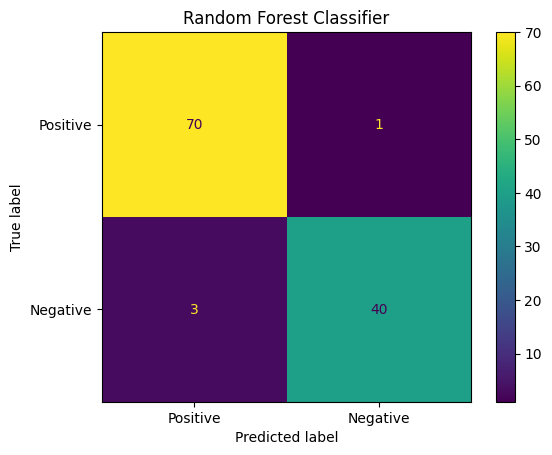

In [51]:
plot_confusion_matrix(rfc, X_test, y_test, values_format='d', display_labels=['Positive','Negative'])
plt.title('Random Forest Classifier')
plt.show() 

### Random Forest Classifier with PCA

Another model i decided to try was RFC with PCA before it, the primary goal of doing so is to reduce the number of features in the dataset and to remove any correlations that may exist between the features. I thought that by removing noisy or irrelevant features, PCA can help to highlight the most important features in the dataset and improve the model's ability to make accurate predictions hence improve the model performance.

In [52]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [53]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_features='sqrt')
clf.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

To perform the grid search on the model, I combined the PCA transformer and the RandomForestClassifier (RFC) estimator into a single object using a pipleine.

In [54]:
pipeline = Pipeline([
    ('pca', pca),
    ('rf', clf)
])

In [55]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [56]:
param_grid = {
    'pca__n_components': [2, 3, 4, 5, 6, 7],
    'rf__n_estimators': [10, 20, 30],
    'rf__max_depth': [5, 10, 20],
    'rf__min_samples_split': [2, 5, 10]
}

In [57]:
grid_search_rfcpca = GridSearchCV(pipeline, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
grid_search_rfcpca.fit(X_train_pca, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pca', PCA(n_components=5)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [2, 3, 4, 5, 6, 7],
                         'rf__max_depth': [5, 10, 20],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [10, 20, 30]},
             scoring='accuracy')

In [58]:
best_pipeline = grid_search_rfcpca.best_estimator_ 
best_pipeline.fit(X_train_pca, y_train)
print(f"Best estimator: {best_pipeline}")

Best estimator: Pipeline(steps=[('pca', PCA(n_components=5)),
                ('rf',
                 RandomForestClassifier(max_depth=5, min_samples_split=5,
                                        n_estimators=30, random_state=42))])


In [59]:
rfcpca_accuracy = best_pipeline.score(X_test_pca, y_test)
print(f"Best Accuracy: {rfcpca_accuracy}")

Best Accuracy: 0.9473684210526315


When combining rfc with pca, the accuracy of the model slightly went down, could be due to loss of valuable information.
However, i had first tried using a number of components of 2 which gave me an accuracy of 99% but a validation score of 92% which makes a huge difference between the two, so i considered it a bad sign since it suggests that the model won't generalize well to new data, making it not a very good model.

In [60]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
nested_scores = cross_val_score(best_pipeline, X_train_pca, y_train, cv=outer_cv, scoring='accuracy', n_jobs=-1, error_score='raise')
print(f"Nested Cross Validation Score: {np.mean(nested_scores)}")

Nested Cross Validation Score: 0.9472527472527472


In [61]:
clf_pred = best_pipeline.predict(X_test_pca)

In [62]:
confusion = confusion_matrix(y_test, clf_pred)
report = classification_report(y_test, clf_pred)
precision = precision_score(y_test, clf_pred)
recall = recall_score(y_test, clf_pred)
f1 = f1_score(y_test, clf_pred)
accuracy = accuracy_score(y_test, clf_pred)
print(f"Confusion Matrix: \n{confusion}")
print(f"Classification Report: \n{report}")
print(f"Precision: {precision_score(y_test, clf_pred)}")
print(f"Recall: {recall_score(y_test, clf_pred)}")
print(f"F1 Score: {f1_score(y_test, clf_pred)}")
print(f"Accuracy: {accuracy_score(y_test, clf_pred)}\n")

Confusion Matrix: 
[[68  3]
 [ 3 40]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

Precision: 0.9302325581395349
Recall: 0.9302325581395349
F1 Score: 0.9302325581395349
Accuracy: 0.9473684210526315



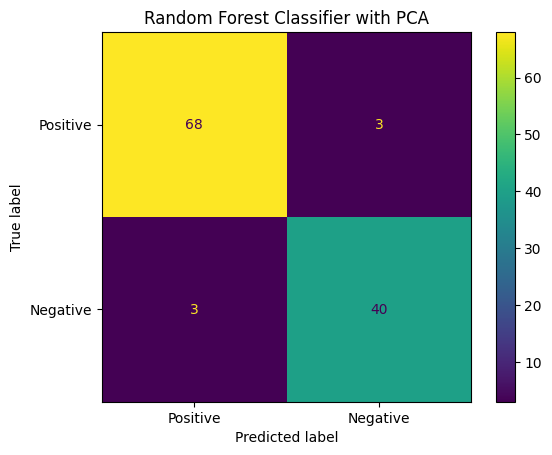

In [63]:
plot_confusion_matrix(best_pipeline, X_test_pca, y_test, values_format='d', display_labels=['Positive','Negative'])
plt.title('Random Forest Classifier with PCA')
plt.show() 

### Decision Trees

I decided to also try decision trees because of its interpretability, ability to handle missing values and outliers, ability to handle large feature sets, and good accuracy.

In [64]:
DT = DecisionTreeClassifier(random_state= 42)
DT.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [65]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [66]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [67]:
grid_search_dt = GridSearchCV(DT, param_grid, cv=cv)
grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [68]:
best_model_dt = grid_search_dt.best_estimator_
DT = best_model_dt
print(f"Best estimator: {DT}")

Best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=5,
                       random_state=42)


In [69]:
DT_accuracy= best_model_dt.score(X_test, y_test)
print("Accuracy on test set:",DT_accuracy)

Accuracy on test set: 0.9473684210526315


In [70]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
nested_scores = cross_val_score(DT, x_scaled, y, cv=outer_cv, scoring='accuracy', n_jobs=-1, error_score='raise')
print(f"Nested Cross Validation Score: {np.mean(nested_scores)}")

Nested Cross Validation Score: 0.9314392175128084


In [71]:
DT_pred = DT.predict(X_test)
DT_pred

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1])

In [72]:
confusion = confusion_matrix(y_test, DT_pred)
report = classification_report(y_test, DT_pred)
precision = precision_score(y_test, DT_pred)
recall = recall_score(y_test, DT_pred)
f1 = f1_score(y_test, DT_pred)
accuracy = accuracy_score(y_test, DT_pred)
print(f"Confusion Matrix: \n{confusion}")
print(f"Classification Report: \n{report}")
print(f"Precision: {precision_score(y_test, DT_pred)}")
print(f"Recall: {recall_score(y_test, DT_pred)}")
print(f"F1 Score: {f1_score(y_test, DT_pred)}")
print(f"Accuracy: {accuracy_score(y_test, DT_pred)}\n")

Confusion Matrix: 
[[70  1]
 [ 5 38]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        71
           1       0.97      0.88      0.93        43

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114

Precision: 0.9743589743589743
Recall: 0.8837209302325582
F1 Score: 0.9268292682926831
Accuracy: 0.9473684210526315



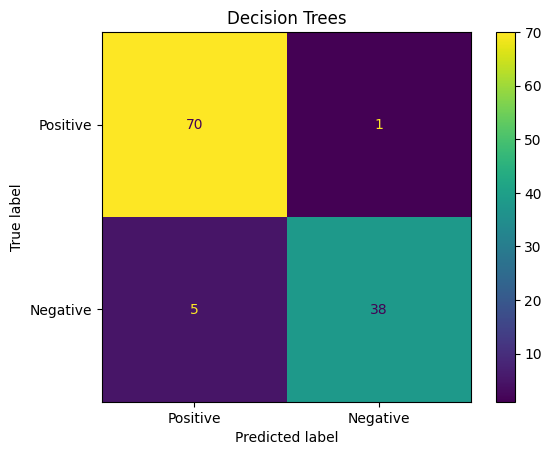

In [73]:
plot_confusion_matrix(DT, X_test, y_test, values_format='d', display_labels=['Positive','Negative'])
plt.title('Decision Trees')
plt.show() 

### Perceptron

The simplicity, efficiency, flexibility, high-dimensional data handling capability, online learning, and good accuracy make the perceptron algorithm a good option for cancer classification.

In [74]:
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=0)
perceptron.fit(X_train, y_train)


Perceptron()

In [75]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [76]:
param_grid_perceptron = {'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'alpha': [0.0001, 0.001, 0.01]}

In [77]:
grid_search_perceptron = GridSearchCV(perceptron, param_grid_perceptron, cv=skf, scoring='f1', error_score='raise')
grid_search_perceptron.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise', estimator=Perceptron(),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='f1')

In [78]:
best_model_perceptron = grid_search_perceptron.best_estimator_
perceptron = best_model_perceptron
print(f"Best estimator: {perceptron}")

Best estimator: Perceptron(max_iter=100, penalty='l1')


In [79]:
perceptron_accuracy = perceptron.score(X_test, y_test)
print(f"Perceptron accuracy: {perceptron_accuracy}")

Perceptron accuracy: 0.9736842105263158


In [80]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
nested_scores = cross_val_score(perceptron, x_scaled, y, cv=outer_cv, scoring='accuracy', n_jobs=-1, error_score='raise')


In [81]:
print(f"Nested Cross Validation Score: {np.mean(nested_scores)}")


Nested Cross Validation Score: 0.9683434249340165


In [82]:
perceptron.fit(X_train, y_train)

Perceptron(max_iter=100, penalty='l1')

In [83]:
y_pred = perceptron.predict(X_test)
y_pred

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1])

In [84]:
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Confusion Matrix: \n{confusion}")
print(f"Classification Report: \n{report}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")

Confusion Matrix: 
[[69  2]
 [ 1 42]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Precision: 0.9545454545454546
Recall: 0.9767441860465116
F1 Score: 0.9655172413793104
Accuracy: 0.9736842105263158



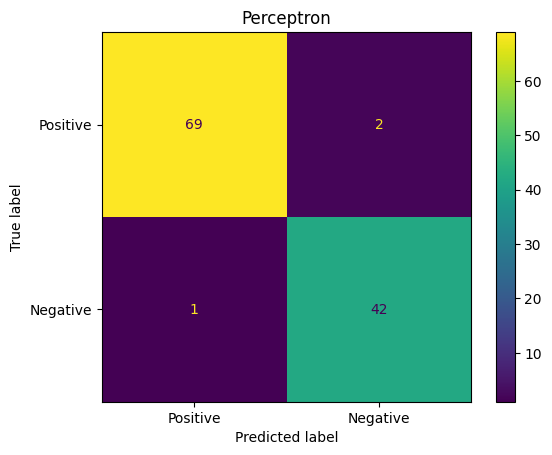

In [85]:
plot_confusion_matrix(perceptron, X_test, y_test, values_format='d', display_labels=['Positive','Negative'])
plt.title('Perceptron')
plt.show() 

### ADABOOST

In [86]:
ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1),
                         n_estimators = 500, 
                         learning_rate = 0.5,
                         random_state=1)

I used the DecisionTreeClassifier with a max depth of 1 used here is a very weak classifier, which is often used to prevent overfitting in the ensemble. 

In [87]:
ada.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=1,
                                                         random_state=1),
                   learning_rate=0.5, n_estimators=500, random_state=1)

In [88]:
Stk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [89]:
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'base_estimator__max_depth': [1, 2, 3],
}

In [90]:
grid_ada = GridSearchCV(ada, param_grid_ada, cv=Stk)
grid_ada.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                max_depth=1,
                                                                                random_state=1),
                                          learning_rate=0.5, n_estimators=500,
                                          random_state=1),
             param_grid={'base_estimator__max_depth': [1, 2, 3],
                         'learning_rate': [0.001, 0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]})

In [91]:
best_estimator_ada = grid_ada.best_estimator_ 
best_estimator_ada = ada
print(f"Best estimator: {best_estimator_ada}")

Best estimator: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=1,
                                                         random_state=1),
                   learning_rate=0.5, n_estimators=500, random_state=1)


In [92]:
ada_accuracy = best_estimator_ada.score(X_test, y_test)
print(f"Best Accuracy: {ada_accuracy}")

Best Accuracy: 0.9824561403508771


In [93]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
nested_scores = cross_val_score(ada, x_scaled, y, cv=outer_cv, scoring='accuracy', n_jobs=-1, error_score='raise')
print(f"Nested Cross Validation Score: {np.mean(nested_scores)}")

Nested Cross Validation Score: 0.9648812296227293


In [94]:
ada_pred = ada.predict(X_test)
ada_pred

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1])

In [95]:
confusion = confusion_matrix(y_test, ada_pred)
report = classification_report(y_test, ada_pred)
precision = precision_score(y_test, ada_pred)
recall = recall_score(y_test, ada_pred)
f1 = f1_score(y_test, ada_pred)
accuracy = accuracy_score(y_test, ada_pred)
print(f"Confusion Matrix: \n{confusion}")
print(f"Classification Report: \n{report}")
print(f"Precision: {precision_score(y_test, ada_pred)}")
print(f"Recall: {recall_score(y_test, ada_pred)}")
print(f"F1 Score: {f1_score(y_test, ada_pred)}")
print(f"Accuracy: {accuracy_score(y_test, ada_pred)}\n")

Confusion Matrix: 
[[71  0]
 [ 2 41]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Precision: 1.0
Recall: 0.9534883720930233
F1 Score: 0.9761904761904763
Accuracy: 0.9824561403508771



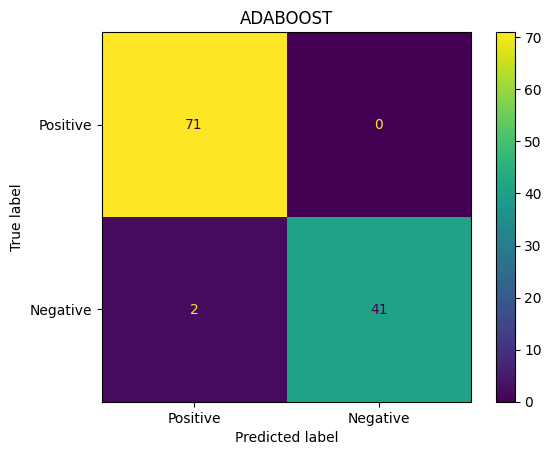

In [96]:
plot_confusion_matrix(ada, X_test, y_test, values_format='d', display_labels=['Positive','Negative'])
plt.title('ADABOOST')
plt.show() 

### XGBOOST

XGBoost is an ensemble method that combines the predictions of multiple weak learners to produce a more accurate model.

In [97]:
xgb = XGBClassifier(n_estimators = 500, learning_rate = 0.01, max_depth=4, random_state=1)

In [98]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [99]:
Stk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [100]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [1, 2, 3, 4],
}

In [101]:
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=Stk)

In [102]:
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_typ...
                                     learning_rate=0.01, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=500, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1, ...),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [50, 100, 200]})

In [103]:
best_estimator_xgb = grid_xgb.best_estimator_ 
xgb = best_estimator_xgb
print(f"Best estimator: {best_estimator_xgb}")

Best estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)


In [104]:
xgb_accuracy = best_estimator_xgb.score(X_test, y_test)
print(f"Best Accuracy: {xgb_accuracy}")

Best Accuracy: 0.9649122807017544


In [105]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
nested_scores = cross_val_score(xgb, x_scaled, y, cv=outer_cv, scoring='accuracy', n_jobs=-1, error_score='raise')
print(f"Nested Cross Validation Score: {np.mean(nested_scores)}")

Nested Cross Validation Score: 0.9613414066138798


In [106]:
xgb_pred = xgb.predict(X_test)
xgb_pred

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1])

In [107]:
confusion = confusion_matrix(y_test, xgb_pred)
report = classification_report(y_test, xgb_pred)
precision = precision_score(y_test, xgb_pred)
recall = recall_score(y_test, xgb_pred)
f1 = f1_score(y_test, xgb_pred)
accuracy = accuracy_score(y_test, xgb_pred)
print(f"Confusion Matrix: \n{confusion}")
print(f"Classification Report: \n{report}")
print(f"Precision: {precision_score(y_test, xgb_pred)}")
print(f"Recall: {recall_score(y_test, xgb_pred)}")
print(f"F1 Score: {f1_score(y_test, xgb_pred)}")
print(f"Accuracy: {accuracy_score(y_test, xgb_pred)}\n")

Confusion Matrix: 
[[70  1]
 [ 3 40]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Precision: 0.975609756097561
Recall: 0.9302325581395349
F1 Score: 0.9523809523809524
Accuracy: 0.9649122807017544



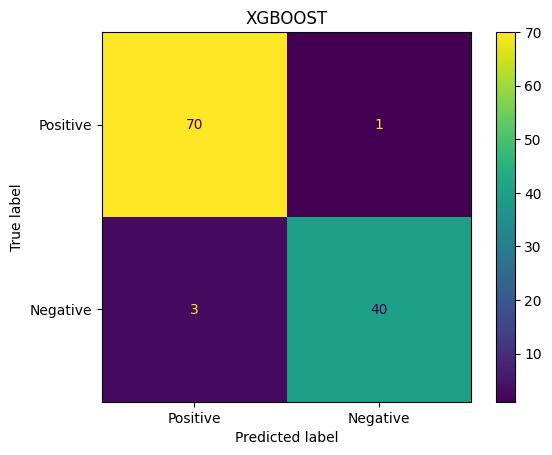

In [108]:
plot_confusion_matrix(xgb, X_test, y_test, values_format='d', display_labels=['Positive','Negative'])
plt.title('XGBOOST')
plt.show() 

## Models Evaluation

### Average accuracy of all models

In [109]:
accuracy = [accuracy_score(y_test, preds) for preds in [lr_pred, knn_pred, rfc_pred, clf_pred, DT_pred, y_pred, ada_pred, xgb_pred]]
precision = [precision_score(y_test, preds) for preds in [lr_pred, knn_pred, rfc_pred, clf_pred, DT_pred, y_pred, ada_pred, xgb_pred]]
recall = [recall_score(y_test, preds) for preds in [lr_pred, knn_pred, rfc_pred, clf_pred, DT_pred, y_pred, ada_pred, xgb_pred]]
f1 = [f1_score(y_test, preds) for preds in [lr_pred, knn_pred, rfc_pred, clf_pred, DT_pred, y_pred, ada_pred, xgb_pred]]

In [110]:
summary_table = pd.DataFrame({
    'Model': ['Logistic Regression', 'K-Nearest Neighbors', 'Random Forest Classifier', 'Random Forest with PCA', 'Decision Trees', 'Perceptron', 'ADABOOST', 'XGBOOST'],
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
})
summary_table.set_index('Model', inplace=True)
print(summary_table)

                          Accuracy  Precision    Recall  F1 Score
Model                                                            
Logistic Regression       0.973684   0.976190  0.953488  0.964706
K-Nearest Neighbors       0.964912   0.953488  0.953488  0.953488
Random Forest Classifier  0.964912   0.975610  0.930233  0.952381
Random Forest with PCA    0.947368   0.930233  0.930233  0.930233
Decision Trees            0.947368   0.974359  0.883721  0.926829
Perceptron                0.973684   0.954545  0.976744  0.965517
ADABOOST                  0.982456   1.000000  0.953488  0.976190
XGBOOST                   0.964912   0.975610  0.930233  0.952381


Some observations that can be deduced:

Logistic Regression, Perceptron, ADABOOST, and Random Forest Classifier are the top-performing models in terms of accuracy, with accuracy scores ranging from 0.973684 to 0.982456.

Although Random Forest Classifier and XGBOOST have similar accuracy scores, Random Forest Classifier has a higher precision score, while XGBOOST has a higher recall score. This suggests that the choice of model may depend on the specific goals of your analysis, such as whether you are more concerned with correctly identifying positive instances or minimizing false positives.

The Random Forest with PCA model has a lower accuracy score than the other models, indicating that the use of PCA to reduce the dimensionality of the data may not be beneficial in this case.

The Decision Trees model has a lower recall score than the other models, which suggests that it may not be as effective at correctly identifying positive instances.

The ADABOOST model has a perfect precision score of 1.0, indicating that it correctly identified all positive instances without any false positives. However, its recall score is lower than some of the other models, indicating that it may have missed some positive instances.



In [111]:
Average_accuracy = (lr_accuracy+knn_accuracy+rfc_accuracy+rfcpca_accuracy+DT_accuracy+perceptron_accuracy+ada_accuracy+xgb_accuracy)/8
Average_accuracy*100

96.49122807017544

I computed the average accuracy since it provides a single number that summarizes the performance of all the models together, making it easier to compare their overall effectiveness. Considering the context of the project and since it is a medial diagnosis, an average accuracy of 96.49% could be considered a good (possibly high) accuracy.

### Ensemble training for the models

The main point of ensemble training is to improve the overall performance and robustness of a machine learning model by combining the predictions of multiple individual models. By doing so, an ensemble model can often achieve higher accuracy and be less prone to overfitting compared to any of its individual components.

In [112]:
vc=VotingClassifier(estimators=[("Logistic Regression",lr),("KNN",knn),("Random Forest",rfc),("Rfc with Pca", pipeline),("Decision Tree",DT), ("Perceptron",  perceptron), ("ADABOOST", ada), ("XGBBOOST", xgb)])
vc.fit(X_train,y_train)

VotingClassifier(estimators=[('Logistic Regression', LogisticRegression()),
                             ('KNN', KNeighborsClassifier(p=1)),
                             ('Random Forest',
                              RandomForestClassifier(max_depth=10,
                                                     random_state=0)),
                             ('Rfc with Pca',
                              Pipeline(steps=[('pca', PCA(n_components=5)),
                                              ('rf',
                                               RandomForestClassifier(random_state=42))])),
                             ('Decision Tree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_dep...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=1, ...))])

The VotingClassifier combines multiple different machine learning models and uses a majority vote to make a final prediction.

In [113]:
vc_pred=vc.predict(X_test)
vc_pred

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1])

In [114]:
Voting_accuracy=accuracy_score(y_test,vc_pred)
Voting_accuracy*100

97.36842105263158

### Refinement of KNN 

From the previous  models, I  have selected one of the best candidate models: K-nearest neighbors. 



In this final step, I re-run the hyperparameter optmization fixing the modelling apporach and varying the hyperparameters in a range close to selected model's one.

In the case of K-nearest neighbors, there are several hyperparameters that can be tuned to potentially improve its performance.

In [115]:
from scipy.stats import randint
param_dist = {
    "n_neighbors": randint(1, 15),
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree"],
    "leaf_size": randint(1, 10),
    "p": [1, 2],
    "metric": ["euclidean", "manhattan", "minkowski"],
    "n_jobs": [-1, 1]
}


In [116]:
random_search = RandomizedSearchCV(
    estimator=best_model_knn,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='f1',
)


In [117]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(p=1),
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree'],
                                        'leaf_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3ad0f40220>,
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_jobs': [-1, 1],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3ad0fb2bb0>,
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   scoring='f1')

In [118]:
rsb = random_search.best_estimator_
rsb

KNeighborsClassifier(algorithm='kd_tree', leaf_size=5, metric='euclidean',
                     n_jobs=1, n_neighbors=7, p=1)

In [119]:
y_pred = rsb.predict(X_test)

In [120]:
f1_score(y_test, y_pred)

0.9302325581395349

In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



Learning curve for KNN:

In [122]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model_knn,
    X=X_train,
    y=y_train,
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    cv=5,
    n_jobs=-1,
    scoring='f1',
    shuffle=False,
    random_state=42,
)



In [123]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

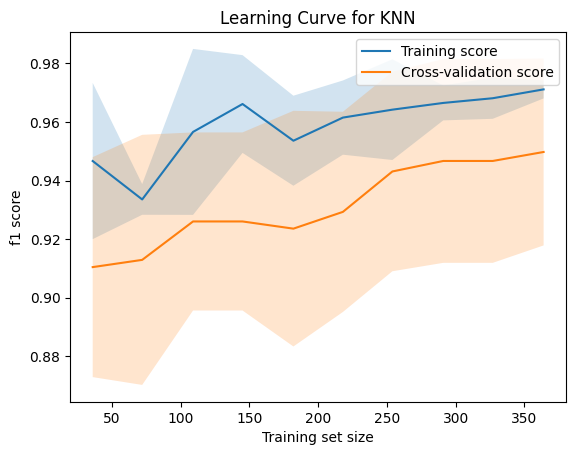

In [124]:
plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

# Add labels and legend to the plot
plt.title('Learning Curve for KNN')
plt.xlabel('Training set size')
plt.ylabel('f1 score')
plt.legend(loc='best')

# Display the plot
plt.show()

The point of this is to show how the model's performance improves as more data is used for training.

Validation Curve of KNN:

In [125]:
estimator= KNeighborsClassifier()
param_range = np.arange(1, 10)
param_name = "n_neighbors"

In [126]:
train_scores, test_scores = validation_curve(
    estimator,
    X = X_train,
    y = y_train,
    param_name=param_name,
    param_range=param_range,
    cv=5,
    scoring="accuracy")

In [127]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

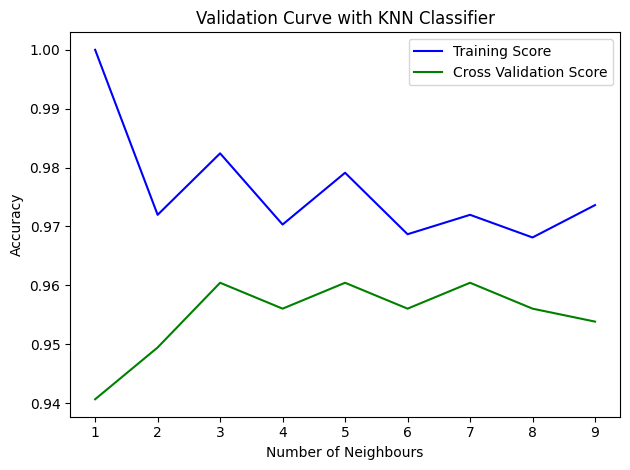

In [128]:
plt.plot(param_range, train_mean,
     label = "Training Score", color = 'b')
plt.plot(param_range, test_mean,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In general, the optimal value of n_neighbors for KNN depends on the complexity of the dataset and the amount of noise present. If the dataset is noisy, a smaller value of n_neighbors might be preferred to smooth out the decision boundary and reduce the effects of noise. However, if the dataset is less noisy and has a well-defined decision boundary, a larger value of n_neighbors might be better to prevent overfitting.

We can observe in the graph that the accuracy is at peak for 3 neighbors: 3,5 and 7.

Since my data is not noisy, i think the optimal number of neighbors is 7.


### Refinement of Logistic Regression

The reason why I refined 2 models was because initially, I had made a mistake: I had put the random state when splitting the data to 30 and continued the project with using a random state of 42. So my best performing models were KRR and logistic regression. However, at the end, i noticed that everytime I ran the project i would get a different Learning curve, and i would tune the hyperparameters to correct it, however, again, i would run the project again and it would change. I tried everything to fix it and my final reason was the randomness of the project, so i figured out I should fix the random state in the split of the data and use the same random state in the whole project to ensure reproducibility, compare results accurately, and avoid introducing bias into my model. 

However, since logistic regression is one of the best performing models, it's a good thing to refine it and to find the optimal hyperparameter values, and try to create a more accurate and robust model that generalizes well to new data.

In [129]:
param_dis = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500, 1000, 5000]
}

In [130]:
random_search = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dis,
    n_iter=10,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    scoring='f1',
    random_state=42,
)

In [131]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=LogisticRegression(),
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'fit_intercept': [True, False],
                                        'max_iter': [100, 500, 1000, 5000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, scoring='f1')

In [132]:
rsb = random_search.best_estimator_
rsb

LogisticRegression(C=100, penalty='l1', solver='saga')

In [133]:
y_pred = rsb.predict(X_test)

In [134]:
f1_score(y_test, y_pred)

0.988235294117647

In [135]:
accuracy_score(y_test, y_pred)

0.9912280701754386

Since the accuracy went up after doing random search, this is a good sign that the model actually improved.

In [136]:
print("Best hyperparameters: ", random_search.best_params_)

Best hyperparameters:  {'solver': 'saga', 'penalty': 'l1', 'max_iter': 100, 'fit_intercept': True, 'C': 100}


In [137]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        71
           1       1.00      0.98      0.99        43

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



Learning Curve for Logistic Regression

In [138]:
pipe = make_pipeline(StandardScaler(), rsb)

In [139]:
train_sizes, train_scores, test_scores = learning_curve(
    pipe,
    X=X_train,
    y=y_train,
    train_sizes=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    cv=5,
    n_jobs=-1,
    scoring='f1',
    shuffle=False,
    random_state=42,
)


In [140]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

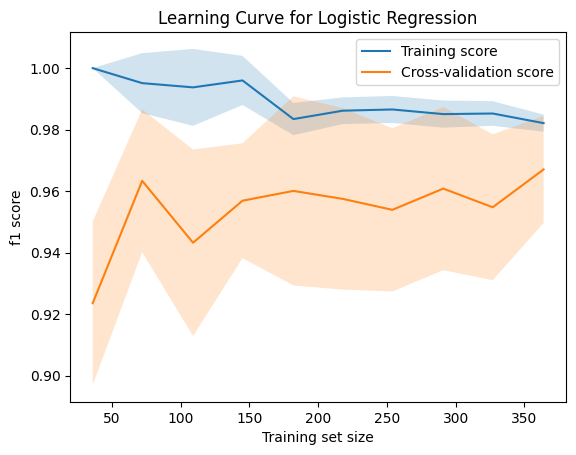

In [141]:
plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

# Add labels and legend to the plot
plt.title('Learning Curve for Logistic Regression')
plt.xlabel('Training set size')
plt.ylabel('f1 score')
plt.legend(loc='best')

# Display the plot
plt.show()

Validation Curve for Logistic Regression

In [142]:
estimator = LogisticRegression(penalty='l2', solver='lbfgs')
param_range = [0.001, 0.01, 0.1, 1, 10, 100]

In [143]:
train_scores, test_scores = validation_curve(
    estimator,
    X = X_train,
    y = y_train,
    param_name="C",
    param_range=param_range,
    cv=5,
    scoring="f1")

In [144]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

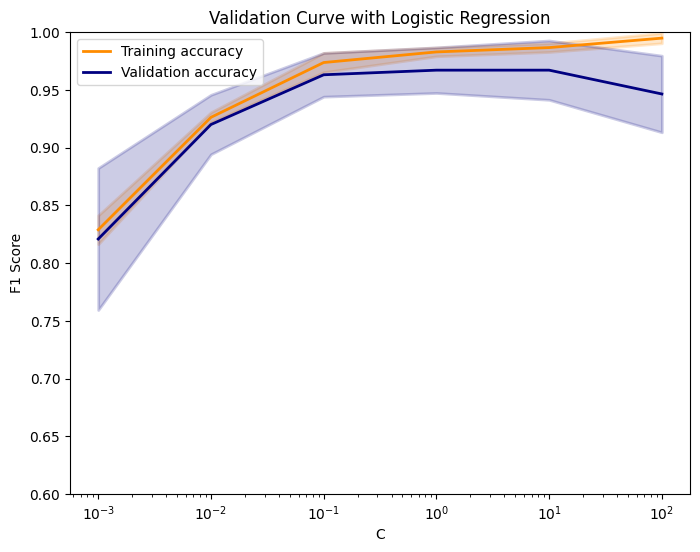

In [145]:
plt.figure(figsize=(8, 6))
plt.title("Validation Curve with Logistic Regression")
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.ylim(0.6, 1.0)
plt.semilogx(param_range, train_mean, label="Training accuracy", color="darkorange", lw=2)
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange", lw=2)
plt.semilogx(param_range, test_mean, label="Validation accuracy", color="navy", lw=2)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="navy", lw=2)
plt.legend(loc="best")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7f1b286e-6704-4e5b-b7f0-b26080e51bbb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>